In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## Using Logistic Model
### https://www.kaggle.com/rizkyalifr/logistic-model-for-indonesia-covid-19

In [0]:
# df=pd.read_csv('indonesia-coronavirus-cases/confirmed_acc.csv')
# df = df.loc[:,['date','cases']]
# FMT = '%m/%d/%Y'

link_cases = 'https://gist.githubusercontent.com/andreasnovian/bd91a4a4d93329f022669aaf8c51f2ab/raw/ae3c26ec212366e0fe3625960db0f6d6f6312b94/cases.csv'
df = pd.read_csv(link_cases, sep = ",")
df = df.loc[:,['date','acc_deceased']]
df = df.dropna()
FMT = '%d-%b-%y'

date = df['date']
# df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("1/22/2020", FMT)).days  )
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("22-Jan-20", FMT)).days  )

In [69]:
print(df.tail())

    date  acc_deceased
16    56          19.0
17    57          25.0
18    58          32.0
19    59          38.0
20    60          48.0


In [0]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [71]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

fit = curve_fit(logistic_model,x,y,p0=[2,100,1000])

A,B = fit
#nilai a,b,c
A

array([ 2.09625189, 58.44222081, 70.07246283])

In [72]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
errors

[0.2587054865153594, 0.7736568905481752, 11.74671834627196]

In [0]:
#Kemungkinan terburuk
a=A[0]+errors[0]
b=A[1]+errors[1]
c=A[2]+errors[2]

In [74]:
#Jumlah hari maksimal dari 2 Maret 
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
sol

70

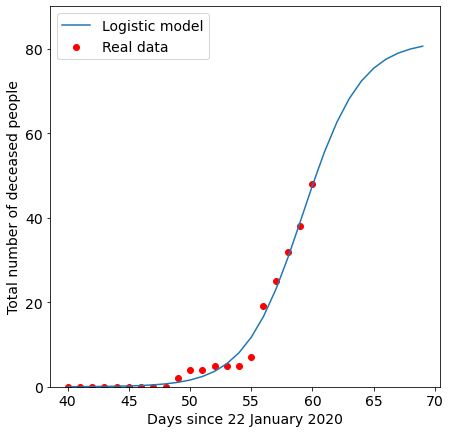

In [75]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,a,b,c) for i in x+pred_x], label="Logistic model" )

plt.legend()
plt.xlabel("Days since 22 January 2020")
plt.ylabel("Total number of deceased people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [76]:
pred_y = [logistic_model(i,a,b,c) for i in pred_x]

for i in range(10):
    
    days = pred_x[i]
    date = datetime.strptime("22-Jan-20", "%d-%b-%y") + timedelta(days=days)
    date = date.isoformat()
    print('Tanggal',date,'Jumlah Korban Meninggal',pred_y[i])

Tanggal 2020-03-22T00:00:00 Jumlah Korban Meninggal 47.658121398484866
Tanggal 2020-03-23T00:00:00 Jumlah Korban Meninggal 55.705202592687996
Tanggal 2020-03-24T00:00:00 Jumlah Korban Meninggal 62.62032103888995
Tanggal 2020-03-25T00:00:00 Jumlah Korban Meninggal 68.15350251789339
Tanggal 2020-03-26T00:00:00 Jumlah Korban Meninggal 72.33356081941888
Tanggal 2020-03-27T00:00:00 Jumlah Korban Meninggal 75.35627041477724
Tanggal 2020-03-28T00:00:00 Jumlah Korban Meninggal 77.47362365919736
Tanggal 2020-03-29T00:00:00 Jumlah Korban Meninggal 78.92394955879564
Tanggal 2020-03-30T00:00:00 Jumlah Korban Meninggal 79.90220749608147
Tanggal 2020-03-31T00:00:00 Jumlah Korban Meninggal 80.55521943944017


In [77]:
y_pred_logistic = [logistic_model(i,a,b,c) for i in x]
p=mean_squared_error(y,y_pred_logistic)

s1=(np.subtract(y,y_pred_logistic)**2).sum()
s2=(np.subtract(y,np.mean(y))**2).sum()
r=1-s1/s2
print("R^2 adalah {}".format(r))
print("Mean square errornya adalah {}".format(p))

R^2 adalah 0.9863367217270059
Mean square errornya adalah 2.684384934532328


In [0]:
from datetime import timedelta, date
from datetime import datetime  
from datetime import timedelta 

start_date = "22/01/20"

date_1 = datetime.strptime(start_date, "%d/%m/%y")

end_date = date_1 + timedelta(days=sol)

end = end_date.strftime("%d %b %Y")

In [79]:
print("Jumlah maksimal pasien meninggal di Indonesia menurut prediksi adalah {:f}".format(A[2]+errors[2])) #Penambahan dengan error
print("Wabah akan berakhir {:.0f} hari setelah 22 Januari 2020 atau {}". format(sol,end))

Jumlah maksimal pasien meninggal di Indonesia menurut prediksi adalah 81.819181
Wabah akan berakhir 70 hari setelah 22 Januari 2020 atau 01 Apr 2020


## Using Prediction Tool: FBProphet
### https://www.kaggle.com/ardisragen/predicting-coronavirus-positive-cases-in-indonesia

In [80]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from fbprophet import Prophet

In [81]:
# link_confirmed_acc = 'https://gist.githubusercontent.com/andreasnovian/e608523a06013478847b171c69a9287c/raw/6d7984d9a31b27657d9822cefdf5e755c650079f/confirmed_acc.csv'
# data = pd.read_csv(link_confirmed_acc, sep = ",")

# print(data.tail())

link_cases = 'https://gist.githubusercontent.com/andreasnovian/bd91a4a4d93329f022669aaf8c51f2ab/raw/ae3c26ec212366e0fe3625960db0f6d6f6312b94/cases.csv'
data = pd.read_csv(link_cases, sep = ",")
data = data.loc[:,['date','acc_deceased']]
data = data.dropna()

print(data.tail())

         date  acc_deceased
16  18-Mar-20          19.0
17  19-Mar-20          25.0
18  20-Mar-20          32.0
19  21-Mar-20          38.0
20  22-Mar-20          48.0


In [82]:
end = datetime.datetime.now() - datetime.timedelta(7)
date_index = pd.date_range('2020-03-02', end)

fig = px.area(data, x=date_index, y='acc_deceased' )
fig.show()

In [83]:
df_prophet = data.rename(columns={"date": "ds", "acc_deceased": "y"})
df_prophet.tail()

,ds,y
16,18-Mar-20,19.0
17,19-Mar-20,25.0
18,20-Mar-20,32.0
19,21-Mar-20,38.0
20,22-Mar-20,48.0


In [84]:
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

m = Prophet(
    changepoint_prior_scale=0.3, # increasing it will make the trend more flexible
    changepoint_range=0.99, # place potential changepoints in the first 95% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


,ds,yhat,yhat_lower,yhat_upper
21,2020-03-23,58.0,56.894115,59.082354
22,2020-03-24,68.0,64.106915,71.771252
23,2020-03-25,78.0,70.568890,85.158760
24,2020-03-26,88.0,76.143226,99.378119
25,2020-03-27,98.0,81.338222,114.040037
26,2020-03-28,108.0,84.669491,128.769698
27,2020-03-29,118.0,88.338868,144.332664
28,2020-03-30,128.0,91.521954,161.093155
29,2020-03-31,138.0,93.772307,177.140057
30,2020-04-01,148.0,96.042281,195.532818


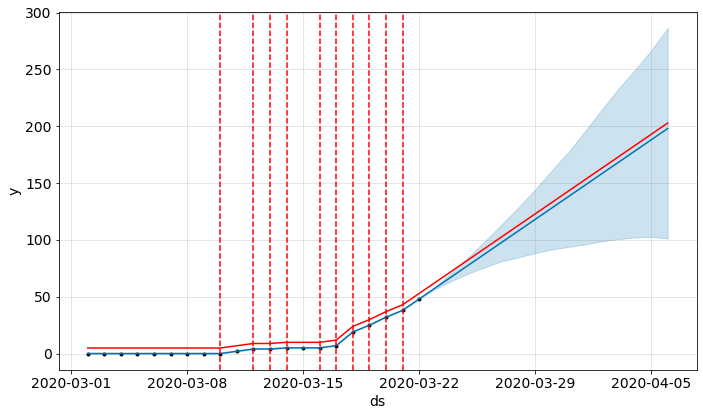

In [85]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [86]:
forecast[50:70]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
